# Lab Assignment 1: Exploring Text Data
## by Aviraj Sinha (Avi) and Cole Ogden

### 1. Business Understanding

All html files are collected from the IMDb archive in the domain of movies. Each of the 30,000 documents is a review and we sample a 1000. The reviews are professionally written and are posted to different online newsgroups. Data collected by Bo Pang and Lillian Lee. http://www.cs.cornell.edu/people/pabo/movie-review-data/


#### Purpose of the Data and Analysis
With the typical blockbuster costing $100,000,000 to produce, film agencies face increasing presuure to deliver a hit that will result in profit for the agency and all investment parties involved. To better understand the human sentiment that goes into creating a powerful hit that resonates with audiences, we sought to understand the audience reception of thousands of movies through the vocabulary collected from thousands of freely available reviews and posts. Since humans are verbal communicators, simple numbers are not an accurate indicator. Numeric rating systems can only describe sentiment to a certain extent and are not always available. By analyzing the sentiment from thousands of movie reviews, we can provide movie production agencies as well as distribution channels a more comprehensive and relevant analysis of a film's reception than numbers alone.

This knowledge of sentiment can be especially beneficial when applied to movie distributers who want a deeper understanding of what qualities make a movie successful before they spend millions to market, manufacture and distribute them through channels (either streamed or physical). This way more financially viable movies can be chosen from studios and sold based on reviews. In the end, distributers make money from lucrative movies and consumers would get what they wanted to watch.

Movie production can have a more certain prediction of a film's financial viability before moving to the larger overhead of production, marketing, and distribution.
Movie distribution channels, such as Netflix, Amazon Prime, HBO, can have a more comprehensive understanding of the movies that their customers enjoy and can better cater their selection of movie deals to the wants of their viewers.

#### Prediction Task
The nuances can become extremely fine-grained with implict meanings such as intent, emotion, subjectivity. However, this prediction task would be a basic polarity analysis, a simple positive or negative, coupled with key words describing them, which is basically enough to take decent advantage of the wealth of data available. 

#### Level of Accuracy
The success of this task would result in basic classification of a review as positive or negative by analyzing vocabulary used. The level of success of this kind of classification depends on the length of the review and the complexity of the language used to describe it. Taking all this together, the required accuracy for this data classification to be of use would be around 90+ percent or above because any false classification could result in the movie not being distributed or wrongly distributed in place of a better performer, thus causing massive losses in revenue through wasted production.



In [1]:
import glob
import re
import string
import itertools
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import words
from yellowbrick.text import FreqDistVisualizer
from stemmer import *
from wordcloud import WordCloud
import stemmer as mystem
warnings.filterwarnings('ignore')
#suffixes from www.thoughco.com
#sentiment vocabulary from:
#http://ptrckprry.com/course/ssd/data/negative-words.txt
#http://ptrckprry.com/course/ssd/data/positive-words.txt

### 2. Data Encoding

#### 2.1 Read in raw text documents

In [2]:

#read in document raw and preprocess
#removing punctutation and return characters as as well as html no_tags
#using fast c level code such as translate and regex to improve speed
#read in as byte code to drastically improve speed
#over 30000 reviews documents in html text format
def preprocess(text):
    text= re.sub(b"<.*?>", b" ", text)#no_tags
    text= re.sub(b"\n", b" ", text)#no_new_lines
    text= re.sub(b"\r", b" ", text)#no_returns
    #lowered with no punctuation
    text= text.translate(None, b'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~').lower()
    #removing the footer for all the reviews
    text= text[:-579]
    return text

char_count=[]#keep track of characters
documents = []
for filename in glob.glob('polarity_html/sample/*.html'):
    with open(filename, 'rb') as f:
        raw = f.read()
        char_count.append(len(raw))
        cleaned = preprocess(raw)
        documents.append(cleaned)


print("Total Documents in Corpus: ", 1000)

#code to see raw vesion
example_raw = open("polarity_html/movie/0002.html")

print("\n************************Raw Version*******************")
print(example_raw.read()[:1000])
#code to view cleaned version
print("\n************************Preprocessed Version*******************\n")
print(documents[0][:1000])
documents = documents[:1000]
char_count = char_count[:1000]

Total Documents in Corpus:  1000

************************Raw Version*******************
<HTML><HEAD>
<TITLE>Review for Hitcher, The (1986)</TITLE>
<LINK REL="STYLESHEET" TYPE="text/css" HREF="/ramr.css">
</HEAD>
<BODY BGCOLOR="#FFFFFF" TEXT="#000000">
<H1 ALIGN="CENTER" CLASS="title"><A HREF="/Title?0091209">Hitcher, The (1986)</A></H1><H3 ALIGN=CENTER>reviewed by<BR><A HREF="/ReviewsBy?Mark+R.+Leeper">Mark R. Leeper</A></H3><HR WIDTH="40%" SIZE="4">
<P>[Editor's note: Sites running 2.10 netnews will munge headers of articles in
moderated  groups *not* named mod.something.  If you get my name instead of
Mark Leeper's in the "From:" line, please encourage your S.A. and your feed's
S.A. to upgrade to 2.11.  Thank you.  And now, on to our review... -ecl]</P>
<PRE>                                 THE HITCHER
                       A film review by Mark R. Leeper
                        Copyright 1987 Mark R. Leeper</PRE>
<P>          Capsule review:  Boring actioner about a psychotic
    

The preprocessing goal is to remove the words generated between html tags, unnessary ascii characters, and the copyright footer. To save memory, character count is used in place of word count and the documents were read in byte code.

#### 2.2 Implement Stemming, convert data from raw text into sparse encoded bag-of-words

In [3]:
#using custom stemmer
analyzer = CountVectorizer(decode_error='ignore').build_analyzer()
def stemmed_words(doc):
    return (mystem.stem(w) for w in analyzer(doc))

#simple count vector using stemmer
count_vect = CountVectorizer(decode_error='ignore', analyzer=stemmed_words)
bag_words = count_vect.fit_transform(documents)
print(bag_words.shape)

df = pd.DataFrame(data=bag_words.toarray(), columns= count_vect.get_feature_names())
df.sum().sort_values()[-20:]

(1000, 33465)


was      4158
on       4227
re       4245
but      4351
be       4472
his      4593
this     5087
with     5214
s        5880
b        5881
for      6139
film     6782
it       6960
that     7868
is      13921
to      17580
        18060
d       19096
of      20039
the     44798
dtype: int64

We encode each document in a corpus as a string in a list of strings.
Decode error parameter is needed in CountVectorizer due to occurence of non-ascii characters.

Implemented stemming using the analyzer parameter in CountVectorizer.
Stemming vocabulary size results:
* 218,754 without stemmer
* 169,256 with professional stemmer
* 198,484 with my basic stemmer remover

#### 2.3 Verify Data Quality, Convert the data into a sparse encoded tf-idf representation.

In [4]:
domain_specific_stop_words = ["movie", "review","reviewed", "copyright", "film", "films", "story", "plot", "director", "characters", "character", "film", "scene", "scenes", "ihnp4mtgzzleeper", "leeper","po", "steve", "mark", "meyer", "1987", "mtgzzleeperrutgersrutgersedu" ]
stop_words = text.ENGLISH_STOP_WORDS.union(domain_specific_stop_words)

#min df ignore term that only occur in 1 percent of documents, max df ifnore therms that occur in more than half of the documents
#removed about 1/4 of the words
tfidf_vect = TfidfVectorizer(stop_words= stop_words, decode_error='ignore', min_df=0.01, max_df=0.70)
tfidf_bag_words = tfidf_vect.fit_transform(documents)
tf_df = pd.DataFrame(data=tfidf_bag_words.toarray(),columns=tfidf_vect.get_feature_names())

#top 10 for each
print("TFDF vector with min and max df and domain-related stop words")
tf_df.sum().sort_values()[-20:]

TFDF vector with min and max df and domain-related stop words


john            15.223768
best            15.385547
make            15.560278
new             15.629140
michael         15.688822
great           16.318341
does            16.524259
people          17.134868
man             17.165995
really          17.574299
1992            17.762477
life            17.993361
1994            18.000932
little          18.582442
time            19.821565
berardinelli    21.331280
1993            21.361420
just            22.642437
james           24.859509
good            26.188263
dtype: float64

Due to the commonality that all documents are professional movie reviews, there will be many redundant words that do not need to be tracked. These would become the domain-related stop words that will be removed due to their lack of useful information. Examples are words like "movie", "film" and "review", as well as critic names and emails. These stop words would be joined with the built-in english stop words and added as a parameter to the vectorizer.

Additional parameters used were the min and max df. Specifically, a min_df of 0.01 means only include the words that occur in at least 1 percent of the corpus, removing specific words like names and places. A max_df of 0.7 means ignore words that occur in more than 70% of the documents.

#### 2.4 Using Bigrams

In [5]:
#bigram count
bigram_count_vect = CountVectorizer(stop_words= stop_words, decode_error='ignore', ngram_range=(2, 2))
#limit set to take a sample because bigram take a while

bigram_bag_words = bigram_count_vect.fit_transform(documents)
print(bigram_bag_words.shape) # this is a sparse matrix
bigram_count_vect.inverse_transform(bigram_bag_words[0])
bi_count_df = pd.DataFrame(data=bigram_bag_words.toarray(),columns=bigram_count_vect.get_feature_names())


# bigram tdidf
bi_tfidf_vect = TfidfVectorizer(stop_words= stop_words, decode_error='ignore', ngram_range=(2, 2), min_df=0.01, max_df=0.70)
#limit set to take a sample because bigram take a while
num_limit = int(len(documents)/100)
bi_tfidf_bag_words = bi_tfidf_vect.fit_transform(documents)
bi_td_df = pd.DataFrame(data=bi_tfidf_bag_words.toarray(), columns=bi_tfidf_vect.get_feature_names())

print("Count---------------")
print(bi_count_df.sum().sort_values()[-10:])
print("\nTFIDF----------------")
print(bi_td_df.sum().sort_values()[-10:])

(1000, 272537)
Count---------------
special effects                     122
date released                       128
ken johnson                         136
berardinelli blake7ccbellcorecom    140
running length                      150
new york                            162
1993 james                          171
frank maloney                       187
scott renshaw                       217
james berardinelli                  573
dtype: int64

TFIDF----------------
ive seen                            16.992311
berardinelli blake7ccbellcorecom    17.381179
running length                      18.460702
special effects                     21.470613
ken johnson                         21.841973
1993 james                          24.657894
new york                            26.118994
scott renshaw                       31.229066
frank maloney                       32.070015
james berardinelli                  71.726725
dtype: float64


Since meaning is taken out of context when tokenizing words into individual components without background knowledge, it is better to understand words that belong together through bigrams. This is done through through the ngram range parameter, which is set in this instance to only find 2-grams. This reveals that different movie terms such as "rate scale" and "science fiction" and popular actor full names.

#### 2.5 Using sentiment vocabulary

##### 2.5.1 Positive and Negative Vocab

In [6]:
#using postive sentiment vocabulary
positive_vocab_file = open("positive_sentiment_indicators.txt","r")
positive_voc = positive_vocab_file.read().split('\n')

pos_count_vect = CountVectorizer(stop_words= stop_words, decode_error='ignore', vocabulary=positive_voc)
pos_bag_words = pos_count_vect.fit_transform(documents)
pos_bag_words.shape
pos_df = pd.DataFrame(data=pos_bag_words.toarray(), columns=positive_voc)

#using negative sentiment vocabulary
negative_vocab_file = open("negative_sentiment_indicators.txt","r")
negative_voc = negative_vocab_file.read().split('\n')

neg_count_vect = CountVectorizer(stop_words= stop_words, decode_error='ignore', vocabulary=negative_voc)
neg_bag_words = neg_count_vect.fit_transform(documents)
neg_bag_words.shape
neg_df = pd.DataFrame(data=neg_bag_words.toarray(), columns=negative_voc)

print("Negatives----------")
print(neg_df.sum().sort_values()[-10:])
print("\nPostives----------")
print(pos_df.sum().sort_values()[-10:])


Negatives----------
problems         168
lost             172
unfortunately    178
evil             206
problem          219
hard             223
death            229
dead             257
funny            361
bad              481
dtype: int64

Postives----------
worth           276
interesting     334
right           399
work            471
love            516
better          549
great           687
best            710
good           1469
like           1615
dtype: int64


In this sentiment bag of words, we used two new vocabularies(positive and negative) using the vocab parameter. The integration of these vocabularies are critical indicators of sentiment levels and will continually be used for our further analysis.

##### 2.5.2 Bigram adverb + sentiment vocab

In [7]:
#bigram with adverb and sentiment vocabulary
adverb_file = open("adverbs.txt","r")
adverbs_voc = adverb_file.read().split('\n')
#cartesian product to add adverbs in front of each sentiment word
adv_neg = list(map( lambda x: x[0]+ " " + x[1], itertools.product(adverbs_voc, negative_voc) ))
adv_pos = list(map( lambda x: x[0]+ " " + x[1], itertools.product(adverbs_voc, positive_voc) ))
adv_with_adj = adv_pos + adv_neg
adv_with_adj = list(set(adv_with_adj))

adv_bi_count_vect = CountVectorizer(stop_words= stop_words, decode_error='ignore', ngram_range=(2, 2), vocabulary=adv_with_adj)
num_limit = int(len(documents)/10)
adv_bi_bag_words = adv_bi_count_vect.fit_transform(documents[:num_limit])
adv_bi_df = pd.DataFrame(data=adv_bi_bag_words.toarray(),columns=adv_bi_count_vect.get_feature_names())

adv_bi_df.sum().sort_values()[-10:]

just good           2
quick dead          2
little better       2
just right          2
far better          2
extremely uneven    2
exactly right       2
pretty good         3
highly recommend    4
lot like            5
dtype: int64

The values in this bag instance are bigrams that are the cartesian products of the adverb and the sentiment vocabulary. This calculation is used to increase the value of a combination during sentiment analysis. For example, an adjective/adverb pair with "not" in front of it will be the exact opposite sentiment, an version with "probably" or "just" would be mediocre, and one with "lot" or "quite" would increase the sentiment value. 

##### 2.5.3 Creating a new Dataframe

In [8]:
#Statistical dataframes by document. columns are pos, neg, vocab size, character number, sentiment vocab numbner and class score
data_stats = pd.DataFrame()
length = pos_bag_words.shape[0]
data_stats['positive_word_count'] = [ pos_count_vect.inverse_transform(pos_bag_words[doc])[0].size for doc in range(length)]
data_stats['negative_word_count'] = [ neg_count_vect.inverse_transform(neg_bag_words[doc])[0].size for doc in range(length)]
#total characters used
data_stats['total_char_count'] = char_count
#positive - negative sentiment words
data_stats["sentiment_score"] = data_stats.apply(lambda row: row.positive_word_count - row.negative_word_count, axis=1)
#how many sentiment vocabs occur
data_stats["sentiment_occurences"] = data_stats.apply(lambda row: row.positive_word_count + row.negative_word_count, axis=1)

def sentiment_level(row):

    if row.sentiment_occurences == 0:
        return "-1 No Sentiment"

    score = row.sentiment_score/row.sentiment_occurences

    if score > 0.333:
        #the good is double the bad
        return "3 Very Good"
    elif score > 0.2:
        #the good is 50% more the bad
        return "2 Good"
    elif score > 0.111:
        #the good is 25% more the bad
        return "1 Alright"
    elif score < -0.333:
        #the bad is double the good
        return "-3 Very Bad"
    elif score < -0.2:
        #the bad is 50% more the good
        return "-2 Bad"
    elif score < -0.111:
        #the bad is 25% more the good
        return "-1 Not Alright"
    else:
        return "0 Neutral"

#0 or 1
data_stats["sentiment_class"] = data_stats.apply(lambda row: 1 if row.sentiment_score>0 else 0, axis=1)
#0-6 rating
data_stats["sentiment_level"] = data_stats.apply(lambda row: sentiment_level(row), axis=1)
data_stats.head()


,positive_word_count,negative_word_count,total_char_count,sentiment_score,sentiment_occurences,sentiment_class,sentiment_level
0,7,6,2957,1,13,1,0 Neutral
1,10,7,3866,3,17,1,1 Alright
2,57,50,13947,7,107,1,0 Neutral
3,30,24,5891,6,54,1,1 Alright
4,11,8,3663,3,19,1,1 Alright


* _sentiment score_ is the difference between postive and negative
* _sentiment occurence_ is the number of times the positive or negative vocabulary was used
* _sentiment class_ is either 0 for negative or 1 for postive. 
* _character count_ was used in place of word count due to memory cost and ease of use
* _sentiment level_ was a arbitrary, manually created categorical variable for ease of understanding/visualizing the different types of documents.

In [9]:
data_stats.describe()


,positive_word_count,negative_word_count,total_char_count,sentiment_score,sentiment_occurences,sentiment_class
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,19.816000,19.47000,5643.904000,0.346000,39.286000,0.518000
std,10.501258,11.93799,2433.374697,9.030051,20.592286,0.499926
min,0.000000,0.00000,1300.000000,-34.000000,0.000000,0.000000
25%,13.000000,11.00000,4174.250000,-5.000000,25.000000,0.000000
50%,18.000000,17.00000,5229.000000,1.000000,36.000000,1.000000
75%,25.000000,25.00000,6168.750000,6.000000,48.000000,1.000000
max,81.000000,86.00000,22380.000000,36.000000,142.000000,1.000000


Creating this data frame can give insight into how different levels of sentiment in an article correlate to different factors such occurences and character count.

### 3. Data Visualization: Visualize statistical summaries of the text data

#### 3.1 Statistical summaries

##### 3.1.1 Distributions

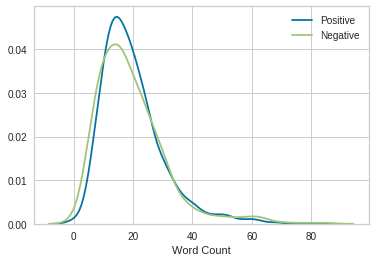

In [10]:
sns.distplot(data_stats.positive_word_count, hist=False, label="Positive");sns.distplot(data_stats.negative_word_count, hist=False,axlabel="Word Count", label="Negative");

The negative and postive term graphs are skewed right indicating that most documents are closer to neutral rather than the few of them with extreme sentiment. Also, since both are similar in shape(unimodal) and range, the quantity and pattern of occurence is similar. The postive word distribution seems to have a higher kurtosis, meaning less variation of word count, whereas negative words have a higher distribution and are more likely to occur less.

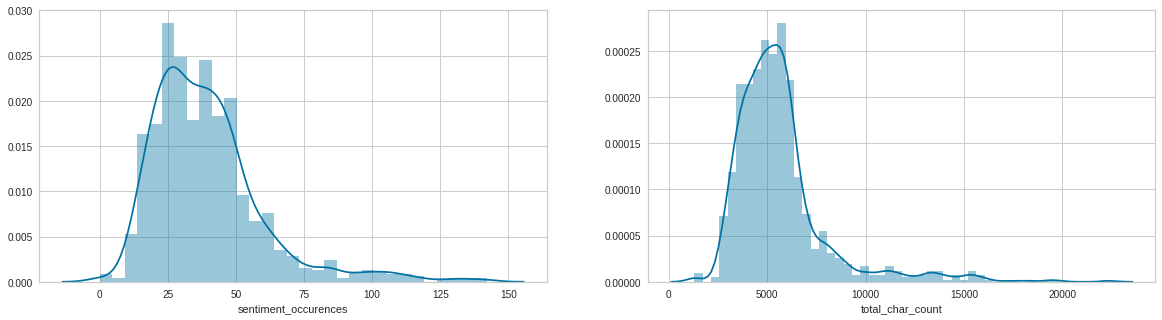

In [11]:
f, axes = plt.subplots(1, 2)
f.set_size_inches(20, 5)
sns.distplot(data_stats.sentiment_occurences, ax=axes[0]);
sns.distplot(data_stats.total_char_count, ax=axes[1]);

Character count and sentiment occurences are both interrelated to each other. Naturally if one writes more, sentiment occurences should increase. One interesting observation would be that they are both skewed right due to the nature of some people to express more sentiment than others. A difference is that the standard format of reviews it makes the character count have a less deviation from the mean, while sentiment occurences have a more free range.

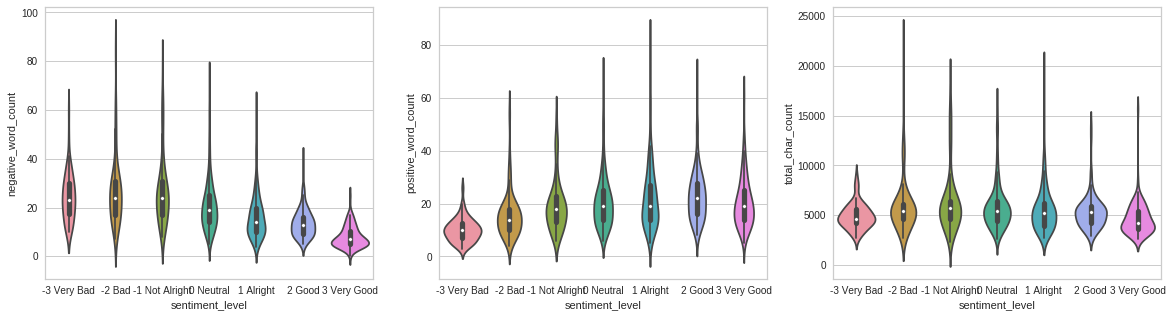

In [12]:
f, axes = plt.subplots(1, 3)

f.set_size_inches(20, 5)
sns.violinplot( x = "sentiment_level", y= "negative_word_count", data=data_stats, order=["-3 Very Bad", "-2 Bad", "-1 Not Alright", "0 Neutral", "1 Alright", "2 Good", "3 Very Good"], ax=axes[0])
sns.violinplot( x = "sentiment_level", y= "positive_word_count", data=data_stats, order=["-3 Very Bad", "-2 Bad", "-1 Not Alright", "0 Neutral", "1 Alright", "2 Good", "3 Very Good"], ax=axes[1])
sns.violinplot( x = "sentiment_level", y= "total_char_count", data=data_stats, order=["-3 Very Bad", "-2 Bad", "-1 Not Alright", "0 Neutral", "1 Alright", "2 Good", "3 Very Good"], ax=axes[2])

Surprising character count has a low median and range for the very bad reviews(Graph#3). The most likely reason is that these are "box office bombs" and aren't even worth mentioning. The very good films also have a low median character count as well having even more reviews with less characters since is is right skewed.

The positive and negative words follow the trend of increasing medians as they correspondingly go up their categories. As mentioned before in the histogram analysis the sentiment occurences have a much higher variation then total character count.

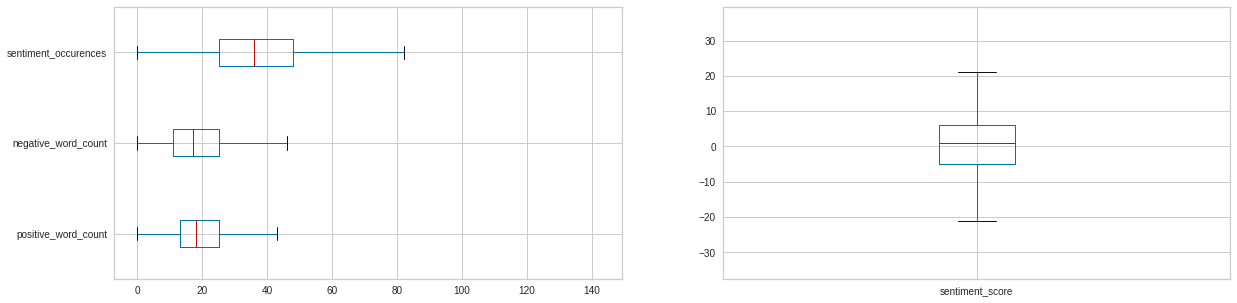

In [13]:
f, axes = plt.subplots(1, 2)
f.set_size_inches(20, 5)

data_stats.boxplot(vert=False,column=['positive_word_count', 'negative_word_count', 'sentiment_occurences'], ax=axes[0])
data_stats.boxplot(column=['sentiment_score'], ax=axes[1])

Since we know distributions are normal from the violin plots we can use box plots to help visualize them. Since the negative and positive word count both make up the sentiment occurences 

##### 3.1.2 Correlations

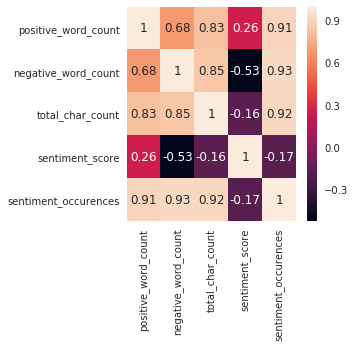

In [14]:
#heatmap
#interesting note that the sentiment score is more related to the negative occurences than positive. Character count related to negativity
drop = data_stats.drop(columns= ["sentiment_class"])
cmap = sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(drop.corr(), cmap=cmap, annot=True)
f.tight_layout()

Key correlation takeaways:
* Notice that the sentiment score is more related to negative occurences than positive. 
* The longer the text, the very high chance (.92) there is more sentiment occurences. 
* Positive and negative terms occur together (.67) meaning that reviews can even be grouped by sentimental and non-sentimental. 
* Sentiment score is more correlated to negative (-.55) then postive word count. Maybe postive words are usually canceld by negative ones. 

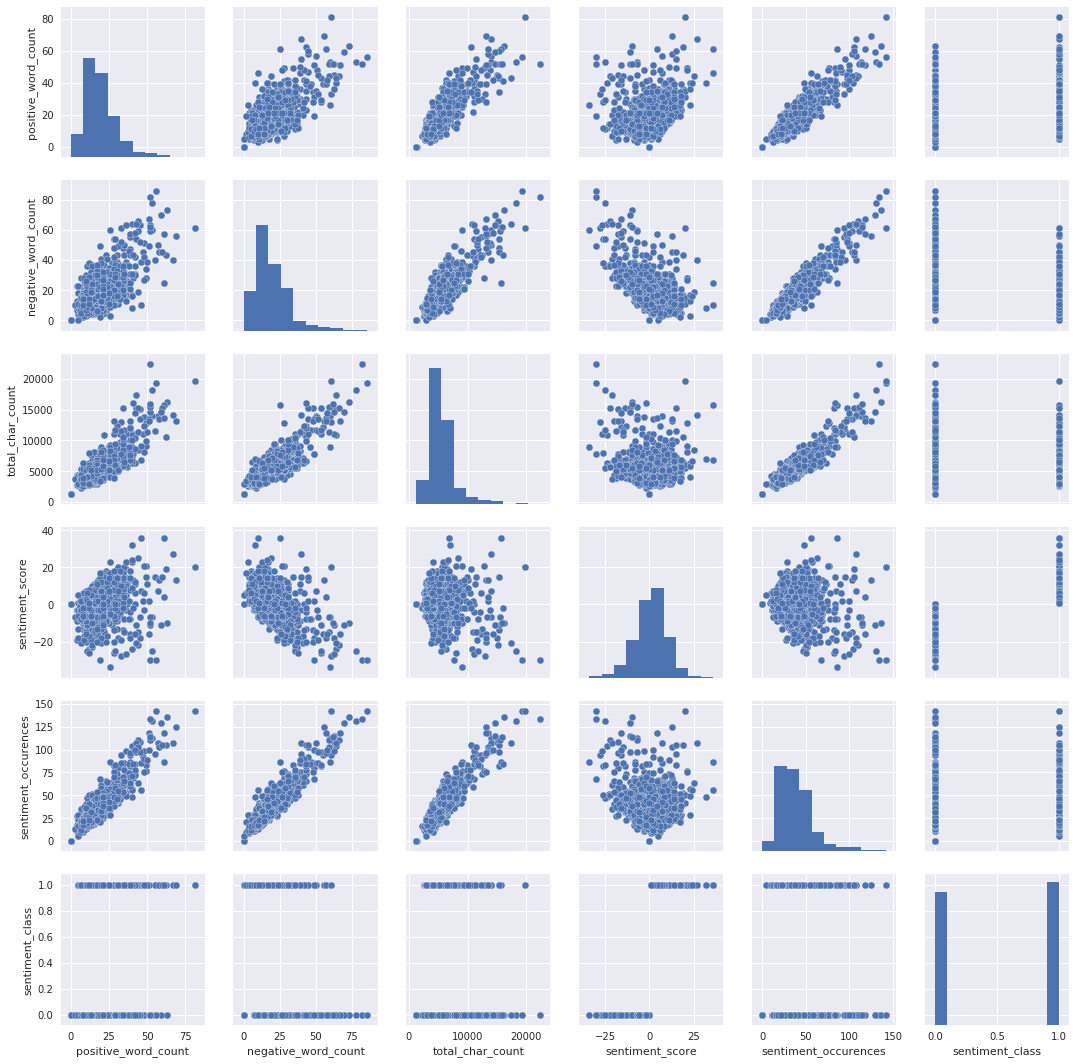

In [15]:
sns.pairplot(data_stats)

In general by looking at the scatter plots the only useful conclusions are that most review are neutral due to cancelation of positive and negative terms and that character count is directly related to sentiment.  This can be seen by looking at the strong correlations of sentiment_occurences column and the normal distribution gathering of the sentiment score.

Surprisingly this means that most reviews were around the neutral range of sentiment meaning they either had less or the sentimental words of both ends of the spectrum canceled out. This is probably because they are by professionals and as a result have reason to reduce emotional bias. At the same time, the decent amount that were sentimental went way past the average range of the characters distribution thus giving a decent correlation.

#### 3.2  Target classes

##### 3.2.1 Bar Chart by Level of Sentiment

In [16]:
df_grouped_sentiments = data_stats.groupby(by='sentiment_level')
for val,grp in df_grouped_sentiments:
    print('There were',len(grp),'reviews sentimental words rated', val)

df_grouped_sentiments.describe()

There were 4 reviews sentimental words rated -1 No Sentiment
There were 113 reviews sentimental words rated -1 Not Alright
There were 105 reviews sentimental words rated -2 Bad
There were 63 reviews sentimental words rated -3 Very Bad
There were 348 reviews sentimental words rated 0 Neutral
There were 158 reviews sentimental words rated 1 Alright
There were 97 reviews sentimental words rated 2 Good
There were 112 reviews sentimental words rated 3 Very Good


negative_word_count                                          \
                              count       mean        std   min   25%   50%   
sentiment_level                                                               
-1 No Sentiment                 4.0   0.000000   0.000000   0.0   0.0   0.0   
-1 Not Alright                113.0  26.663717  14.018872   8.0  17.0  24.0   
-2 Bad                        105.0  26.742857  14.167289   7.0  17.0  24.0   
-3 Very Bad                    63.0  24.428571   9.820509  10.0  17.5  23.0   
0 Neutral                     348.0  20.977011  10.859041   5.0  14.0  19.0   
1 Alright                     158.0  16.348101   8.928540   4.0  10.0  14.0   
2 Good                         97.0  13.731959   5.817566   5.0   9.0  13.0   
3 Very Good                   112.0   7.991071   4.325694   0.0   5.0   7.0   

                             positive_word_count              ...     \
                   75%   max               count       mean   ...      
sentiment_level                                               ...      
-1 No Sentiment   0.00   0.0                 4.0   0.000000   ...      
-1 Not Alright   31.00  78.0               113.0  19.469027   ...      
-2 Bad           31.00  86.0               105.0  15.780952   ...      
-3 Very Bad      30.00  60.0                63.0  10.095238   ...      
0 Neutral        25.00  73.0               348.0  20.859195   ...      
1 Alright        20.00  61.0               158.0  22.322785   ...      
2 Good           16.00  40.0                97.0  23.103093   ...      
3 Very Good      10.25  25.0               112.0  20.500000   ...      

                sentiment_score       total_char_count               \
                            75%   max            count         mean   
sentiment_level                                                       
-1 No Sentiment            0.00   0.0              4.0  1321.000000   
-1 Not Alright            -4.00  -2.0            113.0  6406.469027   
-2 Bad                    -7.00  -3.0            105.0  5996.419048   
-3 Very Bad               -9.50  -5.0             63.0  4937.238095   
0 Neutral                  2.00  13.0            348.0  5901.330460   
1 Alright                  7.75  20.0            158.0  5602.227848   
2 Good                    11.00  27.0             97.0  5325.268041   
3 Very Good               15.25  36.0            112.0  4630.830357   

                                                                         
                         std     min      25%     50%      75%      max  
sentiment_level                                                          
-1 No Sentiment    24.859606  1300.0  1309.00  1313.5  1325.50   1357.0  
-1 Not Alright   3195.498829  2332.0  4596.00  5741.0  6453.00  18244.0  
-2 Bad           2924.812377  2732.0  4624.00  5376.0  6095.00  22380.0  
-3 Very Bad      1263.739085  2702.0  4176.50  4663.0  5586.50   8983.0  
0 Neutral        2399.510877  2558.0  4435.25  5402.5  6409.50  16280.0  
1 Alright        2371.064989  2742.0  3935.50  5199.5  6217.00  19696.0  
2 Good           1717.249330  2879.0  4229.00  5275.0  5875.00  14056.0  
3 Very Good      1606.000886  2649.0  3601.50  4166.0  5429.25  15680.0  

[8 rows x 48 columns]

For each rating from -3,3, we can accurately group a movie reviewer to a classifaction level.
On the range of 3, we can reveal the statistical characteristics of a reviewer who truly loved the movie based on the higher score of sentiment.

Text(0.5,1,'Median Character Count Comparison by sentiment')

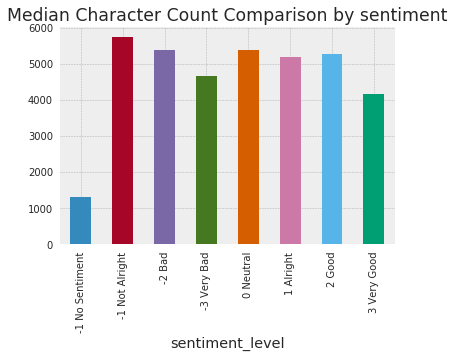

In [17]:
#grouped bar charts for both
plt.style.use('bmh')

character_count = df_grouped_sentiments.total_char_count.median()
ax = character_count.plot(kind='bar')
plt.title('Median Character Count Comparison by sentiment')

This more clearly reveals what we saw before that very good and very bad reviews have less characters, but also bad reviews also have more. 

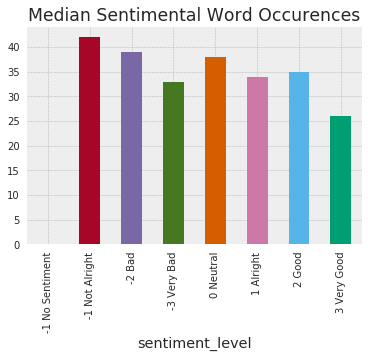

In [18]:
sentiment_occurences = df_grouped_sentiments.sentiment_occurences.median()
ax = sentiment_occurences.plot(kind='bar')
plt.title('Median Sentimental Word Occurences')
plt.show()

The neutral bar chart is show to have more sentimental occurences than the actual postive group. This is from the reason discussed that the sentiment is canceled out because most reviewers try to remain professionally unbiased.

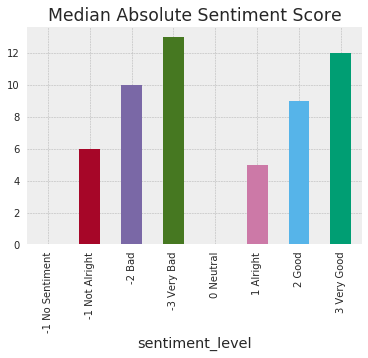

In [19]:
sentiment_score = abs(df_grouped_sentiments.sentiment_score.median())
ax = sentiment_score.plot(kind='bar')
plt.title('Median Absolute Sentiment Score')
plt.show()

All the negative bar graph are the same amount above their positive counter parts. One possible flaw that this might reveal is that all professional movie reviews have short descriptions around the same length, which is usually a form of negative conflict. These short descriptions could be the reason that the negative sentiment score had greater sentiment words numbers in general.

###### 3.2.2 Term Frequencies

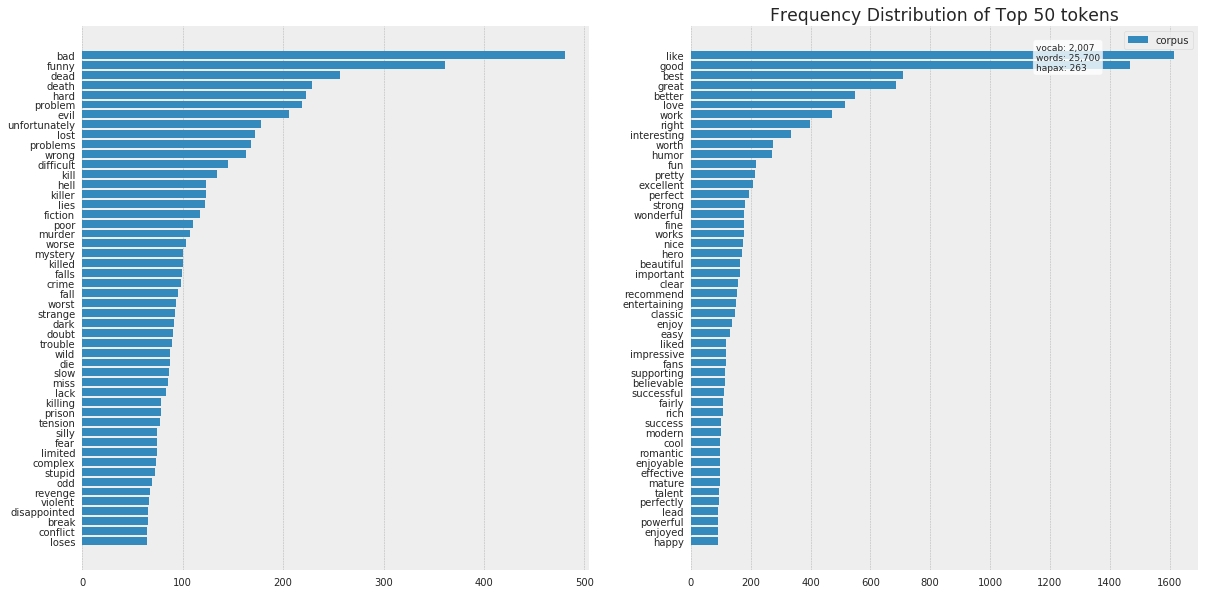

In [20]:
#term frquency charts

f, axes = plt.subplots(1, 2)
f.set_size_inches(20, 10)

neg_features = neg_count_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=neg_features, ax= axes[0])
visualizer.fit(neg_bag_words)

pos_features = pos_count_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=pos_features, ax= axes[1])
visualizer.fit(pos_bag_words)
visualizer.poof()

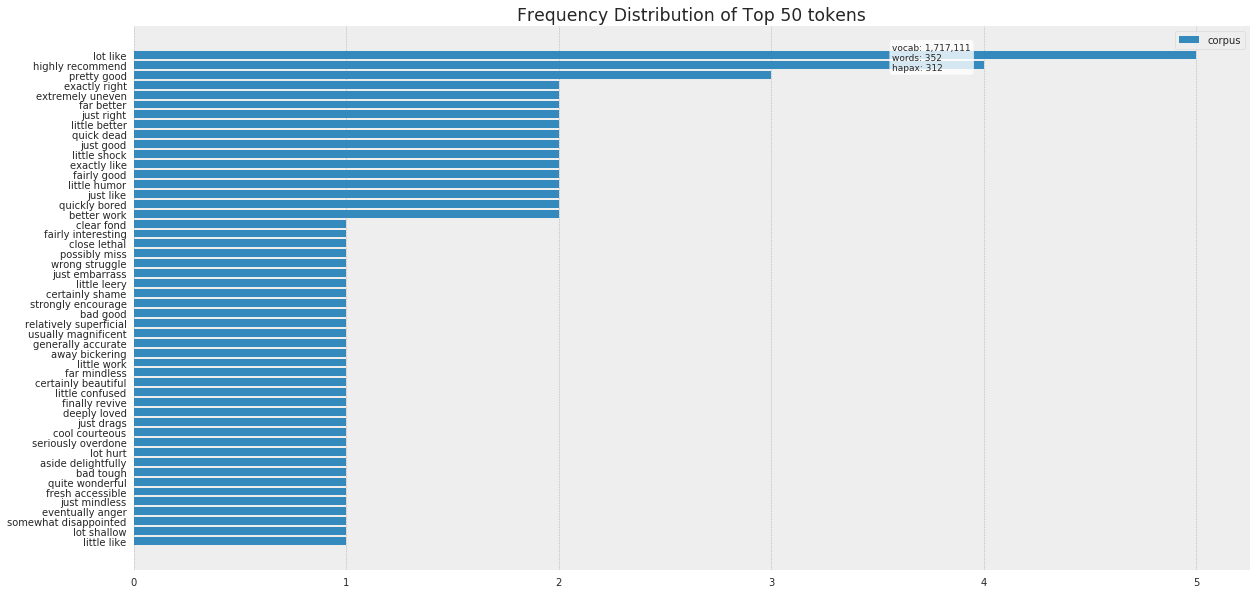

In [21]:
f, axes = plt.subplots(1)
f.set_size_inches(20, 10)
adv_bi_features = adv_bi_count_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=adv_bi_features, ax=axes)
visualizer.fit(adv_bi_bag_words)
visualizer.poof()

Term frequency of positive, negative and bigrams. For each classification, we can view the most frequently used words in the reviews that fall under a given type. This allows us to pair a more accurate assessment between the top words of each group. As a result, we can see that most of the sentiment word occurrences come from a few very common words in both groups and that the negative group in general has more words at play.

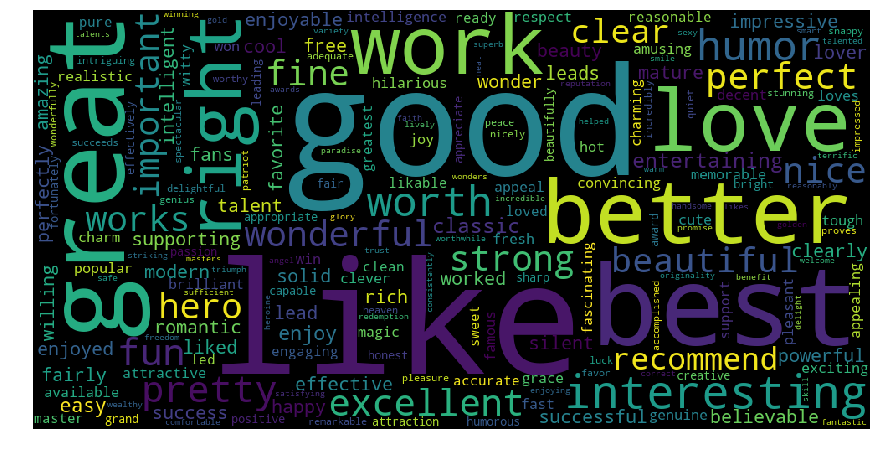

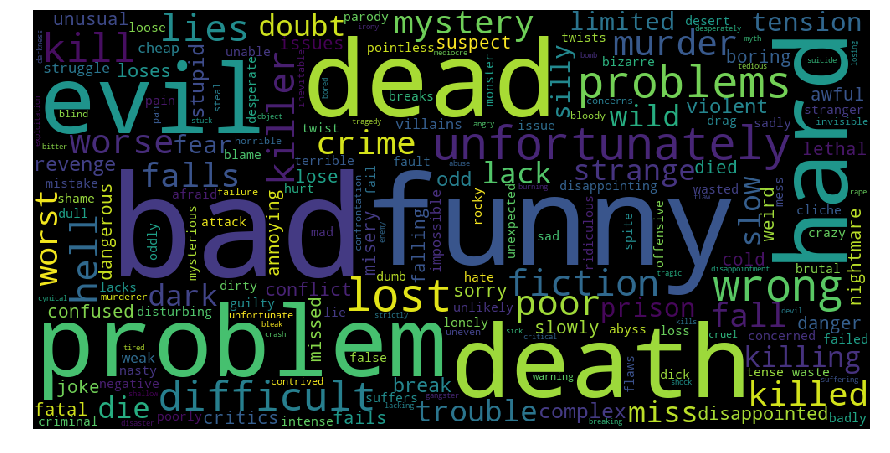

In [22]:
pos_dict = dict(zip(pos_count_vect.get_feature_names(), pos_bag_words.toarray().sum(axis=0)))

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(pos_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()
neg_dict = dict(zip(neg_count_vect.get_feature_names(), neg_bag_words.toarray().sum(axis=0)))

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(neg_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

With the word clouds, we can easily see the most frequently used words in a single glance. By comparing a review's vocabulary to the most frequently used words we can get a more stronger polarity reading of the sentiment value. Reviews with more commonality between the more frequently used positive or negative words fits more with the standard of a positive or negative review. Using this information, we can get an in-depth analysis on how the viewer actually felt while watching the movie. This provides valuable insight to the overall likability of a movie, beyond the context of a 5-star rating.